In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
from AutoEncoderDecoder import EncoderMnist, DecoderMnist, ClassifierMNIST, trainEncoderMNIST, trainClassifierMNIST, evaluateClassifierMNIST 
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [4]:
freeze_seeds(0)

In [5]:
import os
current_dir = os.getcwd()
train_dataset = datasets.MNIST(root=current_dir, train=True, download=False, transform=transform)
test_dataset  = datasets.MNIST(root=current_dir, train=False, download=False, transform=transform)

In [6]:
def print_images(batch_images, num_to_print):
    fig, axes = plt.subplots(1, num_to_print, figsize=(12, 4))

    for i in range(num_to_print):
        image = batch_images[i].detach().numpy().transpose(1, 2, 0)

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.show()

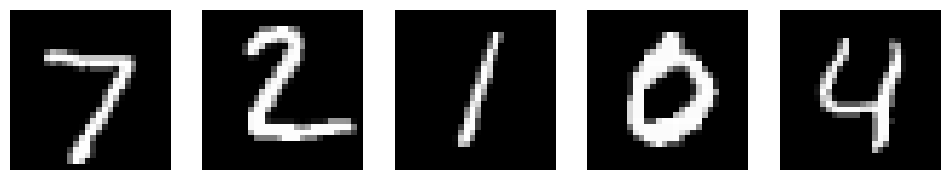

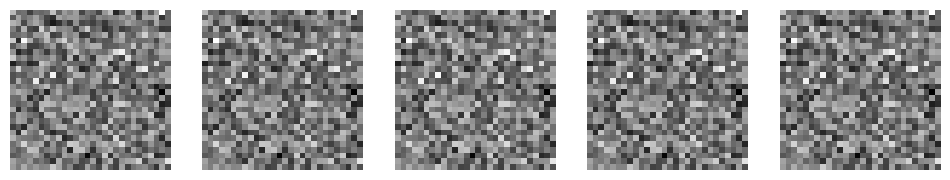

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dl_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=32, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=32, shuffle=False)

im_size = train_dataset[0][0].shape

encoder = EncoderMnist(in_channels=im_size[0] ,latent_dim=128)
decoder = DecoderMnist(latent_dim=128, out_channels=im_size[0])

epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#trainEncoderMNIST(encoder, decoder, epochs, dl_train, dl_val, device=device)

batch_images, batch_labels = next(iter(dl_test))
batch_images = batch_images.to(device)
batch_labels = batch_labels.to(device)

print_images(batch_images, num_to_print=5)
encoded = encoder(batch_images)
decoded = decoder(encoded)
print_images(decoded, num_to_print=5)

# t-SNE
#plot_tsne(encoder, dl_test ,device, "mnist_encoder_1_2_1")

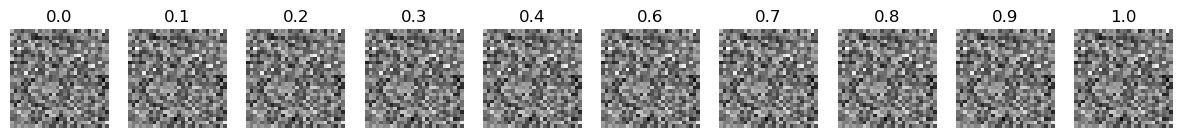

In [8]:
# Find two images with different labels
idx_1, idx_2 = None, None

for i in range(len(batch_labels)):
    for j in range(i + 1, len(batch_labels)):
        if batch_labels[i] != batch_labels[j]:  # Ensure different digits
            idx_1, idx_2 = i, j
            break
    if idx_1 is not None:
        break

# Extract the selected images
x_1, x_2 = batch_images[idx_1], batch_images[idx_2]

z_1 = encoder(x_1.unsqueeze(0))
z_2 = encoder(x_2.unsqueeze(0))

alphas = np.linspace(0, 1, 10)  # Generate 10 interpolation steps

fig = plt.figure(figsize=(15, 8))

for i, alpha in enumerate(alphas):
    z_new = alpha * z_1 + (1 - alpha) * z_2  # Interpolate between z_1 and z_2
    x_new = decoder(z_new)  # Decode back to image

    # Plot the interpolated image
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(x_new.view(28, 28).cpu().data.numpy(), cmap='gray')
    ax.set_axis_off()
    ax.set_title(f"{alpha:.1f}")

plt.show()

In [9]:
# Adding a classifier
print("Section 1.2.1.2")
encoder.eval() # Set encoder to evaluation mode to avoid updates during training

# Freeze the encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

classifier = ClassifierMNIST(latent_dim=128)
epochs = 5
#trainClassifierMNIST(encoder, classifier, epochs, dl_train, dl_val, device)
#evaluateClassifierMNIST(encoder, classifier, dl_test, device)

Section 1.2.1.2


In [10]:
print("Section 1.2.2")
from AutoEncoderDecoder import ClassifierMNIST122, trainClassifierMNIST122, evaluateClassifierMNIST122

encoder_122    = EncoderMnist(in_channels=im_size[0] ,latent_dim=128)
classifier_122 = ClassifierMNIST(latent_dim=128)

model = ClassifierMNIST122(encoder_122, classifier_122).to(device)

# Train the entire model (encoder + classifier) to minimize classification loss
epochs = 5
#trainClassifierMNIST122(model, epochs, dl_train=dl_train, dl_val=dl_val, device=device)
#evaluateClassifierMNIST122(model, dl_test, device)

# t-SNE
#plot_tsne(encoder_122, dl_test ,device, "mnist_encoder_1_2_2")

Section 1.2.2


In [ ]:
from AutoEncoderDecoder import ProjectionHead, trainEncoderMNIST123
print("Section 1.2.3")
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.MNIST(root=current_dir, train=True, download=False, transform=transform)
test_dataset  = datasets.MNIST(root=current_dir, train=False, download=False, transform=transform)

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize encoder, projection head, and loss function
encoder = EncoderMnist(in_channels=im_size[0] ,latent_dim=128)
projection_head = ProjectionHead(in_dim=128, out_dim=128).to(device)
encoder123 = torch.nn.Sequential(encoder, projection_head)

epochs = 3
trainEncoderMNIST123(encoder123, epochs, dl_train, device)

# Add a classifier
classifier123 = ClassifierMNIST(latent_dim=128)
trainClassifierMNIST(encoder123, classifier123, epochs, dl_train, dl_val, device)
evaluateClassifierMNIST(encoder123, classifier123, dl_test, device)

# t-SNE
plot_tsne(encoder, dl_test ,device, "mnist_encoder_1_2_3")

Section 1.2.3
trainEncoder123
